In [ ]:
from common_imports import *
from model_utils import *
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

In [ ]:
model = get_model()

# Experiments for Appendix E.2.

In [ ]:
@batched(args=['texts'], n_outputs=2, reducer='cat', )
def sample_quantities(
    texts: List[str],
    layer: int,
    n_samples: int, 
    batch_size: int = 4,
) -> Tuple[torch.Tensor, torch.Tensor]:
    # resid_mid_node = Node(component_name='resid_mid', layer=layer)
    pre_node = Node(component_name='pre', layer=layer)
    post_node = Node(component_name='post', layer=layer)
    # run the model
    _, ac = model.run_with_cache(texts, names_filter=Node.get_names_filter([
        pre_node, post_node]))
    # extract the activations
    A_pre = pre_node.get_value(ac).squeeze()
    A_post = post_node.get_value(ac).squeeze()
    # these tensors are of shape (batch, num_tokens, dim) where dim is d_model
    # or d_mlp
    # we should concatenate the batch and num_tokens dimensions
    d_mlp = A_post.shape[-1]
    A_pre = A_pre.reshape(-1, d_mlp)
    A_post = A_post.reshape(-1, d_mlp)
    W_out = model.W_out[layer]
    Q, R = torch.linalg.qr(W_out)
    rowspace_projection = Q @ Q.T
    nullspace_projection = torch.eye(d_mlp).cuda() - rowspace_projection
    A_null = A_post @ nullspace_projection
    num_tokens = A_post.shape[0]
    subsets = []
    while len(subsets) < n_samples:
        i, j, k, l = np.random.randint(num_tokens, size=4).tolist()
        if len(set([i, j, k, l])) == 4:
            subsets.append((i, j, k, l))
    xs = []
    ys = []
    subsets_idx = torch.tensor(subsets)
    # index into A_pre using the 4-tuples
    pre_values = A_pre[subsets_idx, :]  # shape (n_samples, 4, d_mlp)
    null_values = A_null[subsets_idx, :]  # shape (n_samples, 4, d_mlp)
    xs = einsum('batch dim, batch dim -> batch', pre_values[:, 0, :] - pre_values[:, 1, :], pre_values[:, 2, :] - pre_values[:, 3, :])
    ys = einsum('batch dim, batch dim -> batch', null_values[:, 0, :] - null_values[:, 1, :], null_values[:, 2, :] - null_values[:, 3, :])
    return torch.tensor(xs), torch.tensor(ys)

In [ ]:
def collect_distortion_data(n_texts: int = 1000):
    for layer in range(12):
        xs, ys = sample_quantities(texts[:n_texts], layer, n_samples=250, batch_size=4)
        joblib.dump((xs, ys), f'data/distortion_data_{layer}.joblib')
        print(f'Layer {layer} done')

In [ ]:
collect_distortion_data()

In [ ]:
# load the data for all layers
xs = []
ys = []
for layer in range(12):
    x, y = joblib.load(f'data/distortion_data_{layer}.joblib')
    xs.append(x)
    ys.append(y)
# make a 4x3 grid of regression plots for all the 12 layers
fig, axes = plt.subplots(4, 3, figsize=(12, 16))
for layer in range(12):
    ax = axes[layer // 3, layer % 3]
    # use a small circle marker to make the plot more readable
    # show the r^2 value, rounded to 2 digits, in the title
    # for visualization, use a subsample of 10k points
    random_sample = np.random.choice(len(xs[layer]), size=10000, replace=False)
    sns.regplot(x=xs[layer].cpu().numpy()[random_sample].tolist(),
                y=ys[layer].cpu().numpy()[random_sample].tolist(),
                ax=ax, scatter_kws={'s': 1})
    reg = LinearRegression().fit(xs[layer].cpu().reshape(-1, 1), ys[layer].cpu().reshape(-1, 1))
    r2 = reg.score(xs[layer].cpu().reshape(-1, 1), ys[layer].cpu().reshape(-1, 1))
    # compute the relative MSE for the regression too
    predictions = reg.predict(xs[layer].cpu().reshape(-1, 1))
    relative_residuals = (ys[layer].cpu().reshape(-1, 1) - predictions) / ys[layer].cpu().reshape(-1, 1)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_title(f'Layer {layer} (r^2 = {r2:.2f})')
plt.tight_layout()
plt.savefig('figures/distortion_regression_plots.pdf')
# plt.show()

In [ ]:
from sklearn.svm import SVC

def represent_as_combination_of_diffs(
    support_indices: Tensor,
    weights: Tensor) -> Tuple[List[Tuple[int, int]], Tensor]:
    """
    We have w_1x_1 + ... + w_nx_n where the sum of w_i is 0.
    
    We rewrite this as
    w_1(x_1-x_2) + (w_2+w_1)(x_2-x_3) + ... + (w_n+...+w_1)(x_n-x_1)
    (note that the last term is 0)
    """
    assert len(support_indices) > 1
    idx_pairs = [(support_indices[i], support_indices[(i+1) % len(support_indices)]) for i in range(len(support_indices))]
    new_weights = [sum(weights[:i+1]) for i in range(len(support_indices))]
    return idx_pairs, torch.Tensor(new_weights)

def check_hypothesis(A_pre: Tensor, A_post: Tensor, 
                     separator: Tensor):
    """
    Given activations before and after the application of a non-linear operation
    f:
    - split the pre-activations into two equal-sized linearly separated groups
    according to their projections on `separator`, 
    - train a hard-margin SVM classifier to split these two groups
    - get the dual weights of the classifier
    - construct the classifier with these weights in the transformed space
    - see how well this new classifier separates the two groups in the
    transformed space, and report the best possible accuracy.
    """
    pre_projections = einsum("batch dim, dim -> batch", A_pre, separator)
    median_proj = torch.median(pre_projections)
    mask_pos = pre_projections > median_proj
    mask_neg = pre_projections <= median_proj
    labels = torch.ones_like(pre_projections)
    labels[mask_neg] = 0
    clf = SVC(kernel="linear", C=1e10)
    clf.fit(A_pre.cpu(), labels.cpu())
    support_indices = clf.support_
    dual_weights = torch.Tensor(clf.dual_coef_).squeeze().to(A_pre.device)
    pre_separator = dual_weights @ A_pre[support_indices, :]
    print(pre_separator.cpu().numpy() - clf.coef_)
    post_separator = dual_weights @ A_post[support_indices, :]
    # check the best possible accuracy for the post separator
    post_projections = einsum("batch dim, dim -> batch", A_post, post_separator)
    best_acc = 0
    for i in range(len(post_projections)):
        # accuracy if we split at this point
        acc_pos_top = ((post_projections > post_projections[i]).float() == labels).float().mean()
        acc_neg_top = ((post_projections <= post_projections[i]).float() == labels).float().mean()
        if acc_pos_top > best_acc:
            best_acc = acc_pos_top
        if acc_neg_top > best_acc:
            best_acc = acc_neg_top
    
    ### check how expressing the post-separator as a combination of diffs works
    diff_pairs, diff_weights = represent_as_combination_of_diffs(support_indices, dual_weights)
    decomposition_vectors_pre = [weight * (A_pre[idx1, :] - A_pre[idx2, :]) for (idx1, idx2), weight in zip(diff_pairs, diff_weights)]
    decomposition_vectors_post = [weight * (A_post[idx1, :] - A_post[idx2, :]) for (idx1, idx2), weight in zip(diff_pairs, diff_weights)]
    # sample random pairs of points from class 1 and class 0 
    indices_class_1 = torch.where(labels == 1)[0]
    indices_class_0 = torch.where(labels == 0)[0]
    # collect 1000 random samples from `indices_class_1`
    # and 1000 random samples from `indices_class_0`
    # and check how well the post-separator separates them
    idxs1 = torch.Tensor([random.choice(indices_class_1) for _ in range(1000)]).long().to(A_pre.device)
    idxs2 = torch.Tensor([random.choice(indices_class_0) for _ in range(1000)]).long().to(A_pre.device)
    terms_pre = torch.stack([einsum("samples dim, dim -> samples", A_pre[idxs1, :] - A_pre[idxs2, :], v) for v in decomposition_vectors_pre], -1)
    terms_post = torch.stack([einsum("samples dim, dim -> samples", A_post[idxs1, :] - A_post[idxs2, :], v) for v in decomposition_vectors_post], -1)
    return best_acc, terms_pre, terms_post

@batched(args=['texts'], n_outputs=2, reducer='cat', )
def collect_activations(
    texts: List[str],
    layer: int,
    n_samples: int = 100,
    batch_size: int = 4,
) -> Tuple[torch.Tensor, torch.Tensor]:
    # resid_mid_node = Node(component_name='resid_mid', layer=layer)
    pre_node = Node(component_name='pre', layer=layer)
    post_node = Node(component_name='post', layer=layer)
    # run the model
    _, ac = model.run_with_cache(texts, names_filter=Node.get_names_filter([
        pre_node, post_node]))
    # extract the activations
    A_pre = pre_node.get_value(ac).squeeze()
    A_post = post_node.get_value(ac).squeeze()
    # these tensors are of shape (batch, num_tokens, dim) where dim is d_model
    # or d_mlp
    # we should concatenate the batch and num_tokens dimensions
    d_mlp = A_post.shape[-1]
    A_pre = A_pre.reshape(-1, d_mlp)
    A_post = A_post.reshape(-1, d_mlp)
    W_out = model.W_out[layer]
    Q, R = torch.linalg.qr(W_out)
    rowspace_projection = Q @ Q.T
    nullspace_projection = torch.eye(d_mlp).cuda() - rowspace_projection
    A_null = A_post @ nullspace_projection
    # sample a mask of n_samples nonzeros
    mask = torch.zeros(A_pre.shape[0]).cuda().bool()
    mask[np.random.choice(A_pre.shape[0], n_samples, replace=False)] = 1
    return A_pre[mask], A_null[mask]

In [ ]:
### main experiment to check theory w/ SVM classifier
NUM_RANDOM_DIRECTIONS = 10
dataset = model.load_sample_training_dataset()
total_examples = len(dataset)
print(f'Total examples: {total_examples}')
texts = [dataset[i]['text'] for i in range(total_examples)]
A_pre, A_null = collect_activations(texts[:100], layer=8, n_samples=100, batch_size=4)
for i in range(NUM_RANDOM_DIRECTIONS):
    separator = torch.randn(3072).cuda()
    best_acc, terms_pre, terms_post = check_hypothesis(A_pre=A_pre, A_post=A_null, separator=separator)
    print(f'Best accuracy: {best_acc}')
    terms_pre_cumsums = torch.cumsum(terms_pre_stacked, -1)
    terms_post_cumsums = torch.cumsum(terms_post_concat, -1)
    same_sign = (terms_pre_cumsums > 0) == (terms_post_cumsums > 0)
    same_sign_avg = same_sign.float().mean(-1).mean()
    print(f'Same sign: {same_sign_avg}')

# W_out/W_in singular value experiments (Appendix E.5)

In [ ]:
model = HookedTransformer.from_pretrained_no_processing(model_name='gpt2-small').requires_grad_(False)

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-small into HookedTransformer


In [ ]:
model.W_in[0].shape

torch.Size([768, 3072])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

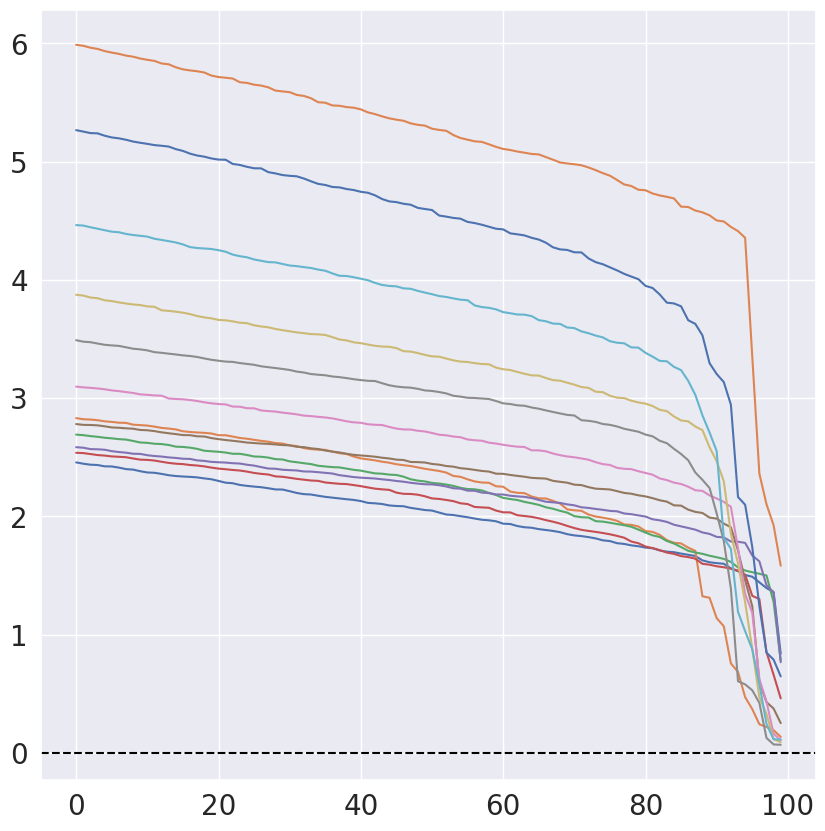

In [ ]:
# plot the singular values of each of model.W_out[i] for i in range(12)
# in the same line plot
# x axis is the singular value index
# y axis is the singular value
# color is the layer index
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
for i in range(12):
    U, S, VT = torch.linalg.svd(model.W_out[i])
    ax.plot(S[-100:].cpu(), label=f'layer {i}')
# put a horizontal dashed line at 0
ax.axhline(0, linestyle='--', color='black')
ax.tick_params(axis='both', which='major', labelsize=20)
# ax.legend()
plt.savefig(f'figures/singular_out.pdf', format='pdf')
plt.show()

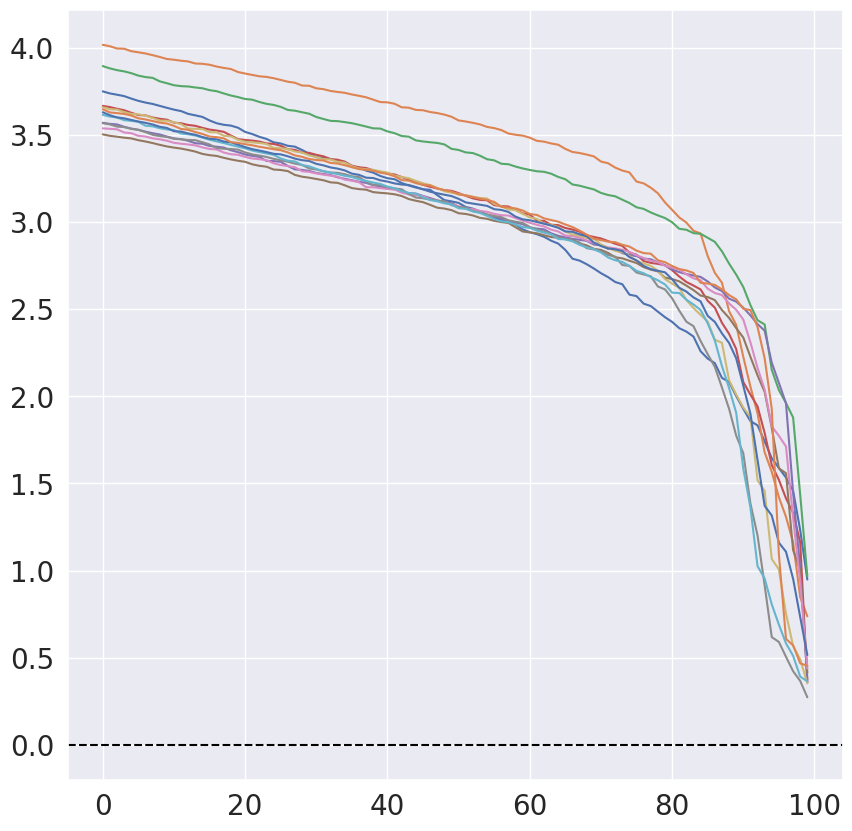

In [ ]:
# plot the singular values of each of model.W_out[i] for i in range(12)
# in the same line plot
# x axis is the singular value index
# y axis is the singular value
# color is the layer index
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
for i in range(12):
    U, S, VT = torch.linalg.svd(model.W_in[i])
    ax.plot(S[-100:].cpu(), label=f'layer {i}')
# put a horizontal dashed line at 0
ax.axhline(0, linestyle='--', color='black')
ax.tick_params(axis='both', which='major', labelsize=20)
plt.savefig(f'figures/singular_in.pdf', format='pdf')
plt.show()